In [1]:
import torch, torchvision
from torch.utils.data import Subset
import torchvision.models as models
from torchvision import transforms as T
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/transfer_results/"

Mounted at /content/drive


# Configure Experiment

In [85]:
config = {
    'experiment_name': 'bright_sat',
    'lr': 0.01,
    'batch_size': 64,
    'epochs':10,
    'val_epochs': 2,
    'cpt_epochs': [3,6,9],
    'freeze_layers':False
}

In [95]:
no_augment = []
identity_augment = [T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]

crop_augment = [T.CenterCrop(20)]
blur_augment = [T.GaussianBlur(kernel_size=(3,3))]
flip_augment = [T.RandomHorizontalFlip(p=0.5)]
rotate_augment = [T.RandomAffine(degrees=(-45,45))]
trans_scale_augment = [T.RandomAffine(degrees = 0, scale=(0.8,1.2), translate=(0.2,0.2))]
gray_augment = [T.RandomGrayscale(0.2)]
bright_sat_augment = [T.ColorJitter(brightness=0.5,saturation=0.5)]




selected_augment = bright_sat_augment # Change augment here


augmentation = T.Compose(selected_augment + identity_augment)

# Initialize model and load data

In [87]:
# Make directories to save stuff
pathlib.Path(f'{base_dir}cpts').mkdir(exist_ok=True) 
pathlib.Path(f'{base_dir}plots').mkdir(exist_ok=True) 
pathlib.Path(f'{base_dir}preds').mkdir(exist_ok=True) 

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert(device=='cuda')

In [89]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.to(device)
None

In [90]:
if config['freeze_layers']:
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    # for param in model.layer4.parameters():
    #     param.requires_grad = True

In [91]:
cifar_train = torchvision.datasets.CIFAR10("CIFAR_train", train=True, download=True, transform=augmentation)
cifar_test = torchvision.datasets.CIFAR10("CIFAR_test", train=False, download=True, transform=T.Compose(identity_augment))
cifar_debug = torchvision.datasets.CIFAR10("CIFAR_test", train=False)
len(cifar_train), len(cifar_test)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [92]:
trainloader = torch.utils.data.DataLoader(cifar_train,
                                          batch_size=config['batch_size'],
                                          shuffle=False,
                                          num_workers=1)
testloader = torch.utils.data.DataLoader(cifar_test,
                                          batch_size=config['batch_size'],
                                          shuffle=False,
                                          num_workers=1)    

7


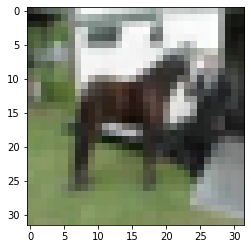

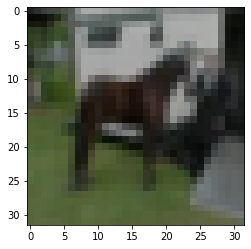

In [97]:
#Visualize
image, label = cifar_debug[20]
invTrans = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                T.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               T.ToPILImage()
                               ])
plt.figure()
plt.imshow(image)

plt.figure()
plt.imshow(invTrans(augmentation(image)))
print(label)

# Training

In [98]:
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'])
crit = torch.nn.CrossEntropyLoss()
train_losses = []
val_losses = []

for epoch in range(config['epochs']):
  tq = tqdm.tqdm(trainloader)
  
  train_loss_sum = 0

  val_loss_sum = 0


  for (data, gt) in tq:
    data = data.to(device)
    gt = gt.to(device)
    with torch.enable_grad():
      pred = model(data)
      loss = crit(pred, gt)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss_sum += loss

  
  # val
  if epoch % config['val_epochs'] == 0:
    for (data,gt) in testloader:
      data = data.to(device)
      gt = gt.to(device)
      pred = model(data)
      loss = crit(pred,gt)
      val_loss_sum+=loss
      
    val_loss_avg = val_loss_sum / len(testloader)
    val_losses.append(val_loss_avg.item())

  if epoch in config['cpt_epochs']:
    torch.save(model.state_dict(), f"{base_dir}cpts/{config['experiment_name']}-ep{epoch}")

  train_loss_avg = train_loss_sum / len(trainloader)
  train_losses.append(train_loss_avg.item())
  print(f"Ep {epoch} Train loss: {train_loss_avg} Val loss: {val_loss_avg}")

100%|██████████| 782/782 [00:41<00:00, 18.97it/s]


Ep 0 Train loss: 1.692634105682373 Val loss: 1.4290896654129028


100%|██████████| 782/782 [00:40<00:00, 19.20it/s]


Ep 1 Train loss: 1.2936221361160278 Val loss: 1.4290896654129028


100%|██████████| 782/782 [00:41<00:00, 18.85it/s]


Ep 2 Train loss: 1.0824896097183228 Val loss: 0.999483048915863


100%|██████████| 782/782 [00:40<00:00, 19.48it/s]


Ep 3 Train loss: 0.9656001925468445 Val loss: 0.999483048915863


100%|██████████| 782/782 [00:40<00:00, 19.18it/s]


Ep 4 Train loss: 0.9270113110542297 Val loss: 0.9363728165626526


100%|██████████| 782/782 [00:38<00:00, 20.11it/s]


Ep 5 Train loss: 0.7978445291519165 Val loss: 0.9363728165626526


100%|██████████| 782/782 [00:39<00:00, 19.74it/s]


Ep 6 Train loss: 0.7245683670043945 Val loss: 0.8890470266342163


100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


Ep 7 Train loss: 0.6662673950195312 Val loss: 0.8890470266342163


100%|██████████| 782/782 [00:39<00:00, 19.69it/s]


Ep 8 Train loss: 0.6044341325759888 Val loss: 0.9011979699134827


100%|██████████| 782/782 [00:39<00:00, 20.01it/s]


Ep 9 Train loss: 0.5459122061729431 Val loss: 0.9011979699134827


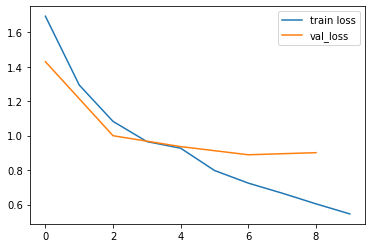

In [99]:
fig1 = plt.gcf()
plt.plot(train_losses, label='train loss')
plt.plot(np.arange(0,config['val_epochs']*len(val_losses),config['val_epochs']),val_losses, label='val_loss')
plt.legend()
fig1.show()

In [100]:
preds = []
gts = []
for (X,y) in tqdm.tqdm(testloader):
  X = X.to(device)
  yhat = model(X).argmax(axis=1).tolist()
  preds += yhat
  gts += y.tolist()
preds = np.array(preds)
gts = np.array(gts)

100%|██████████| 157/157 [00:04<00:00, 37.92it/s]


In [101]:
(preds==gts).mean()

0.711

## Save plots and predictions

In [102]:
with open(f"{base_dir}preds/{config['experiment_name']}.npy",'wb') as outfile:
  np.save(outfile,preds)

In [103]:
fig1.savefig(f"{base_dir}plots/{config['experiment_name']}.jpg")

# Evaluation